# Set up 

In [19]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

In [20]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll
os.chdir('notebooks/all_data/')

# Perturbing enzymes

In [21]:
Teusink_ant ='../../data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [22]:
BIOMD64_15 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv')


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

../../data/interim/Antimony/BIOMD0000000064_e_cobra.ant


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 12,409


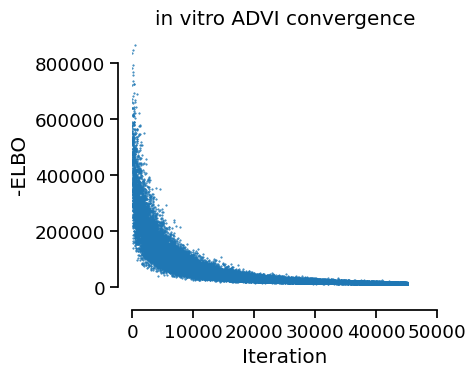

In [23]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, 50000])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)

trace_ADVI = run_ADVI(BIOMD64_15)

In [24]:
BMCA_obj = BIOMD64
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
    pm.Deterministic('en', e_obs)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
    pm.Deterministic('chin', chi_obs)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
    pm.Deterministic('yn', y_obs)
    likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    pm.Deterministic('v_hat', v_hat_obs)

    trace = pm.sample(1000, random_seed=1, cores=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: Ru

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4889 seconds.


In [25]:
Ex = (trace['posterior']['Ex']).to_numpy()
Ey = (trace['posterior']['Ey']).to_numpy()
Ex_advi = (trace_ADVI['posterior']['Ex']).to_numpy().squeeze()
Ey_advi = (trace_ADVI['posterior']['Ey']).to_numpy().squeeze()

In [26]:
def reshape_elasticity(E):
    tmp = []
    for i in E: 
        tmp.append(i)
    return np.concatenate(tmp)

Ex = reshape_elasticity(Ex)
Ey = reshape_elasticity(Ey)

C:\Users\user\AppData\Local\Temp\ipykernel_13800\653967958.py:20: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



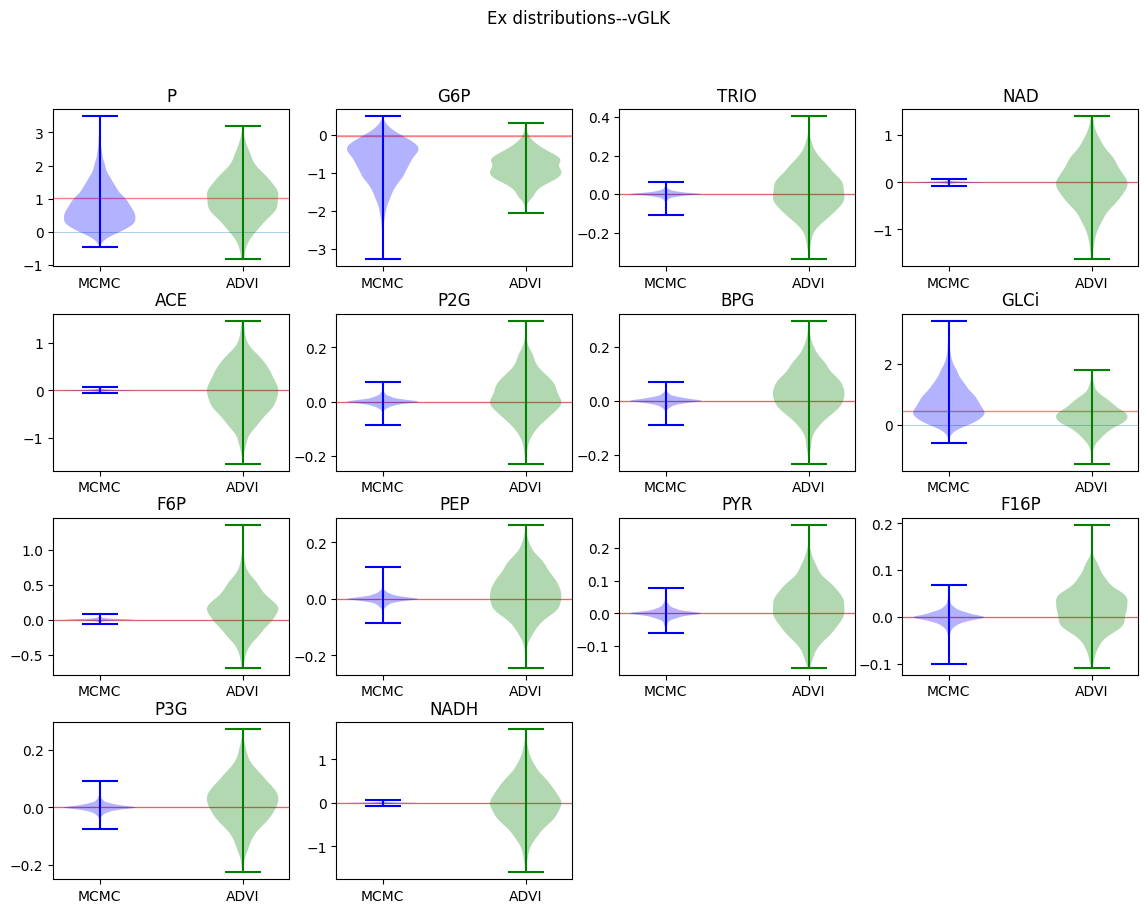

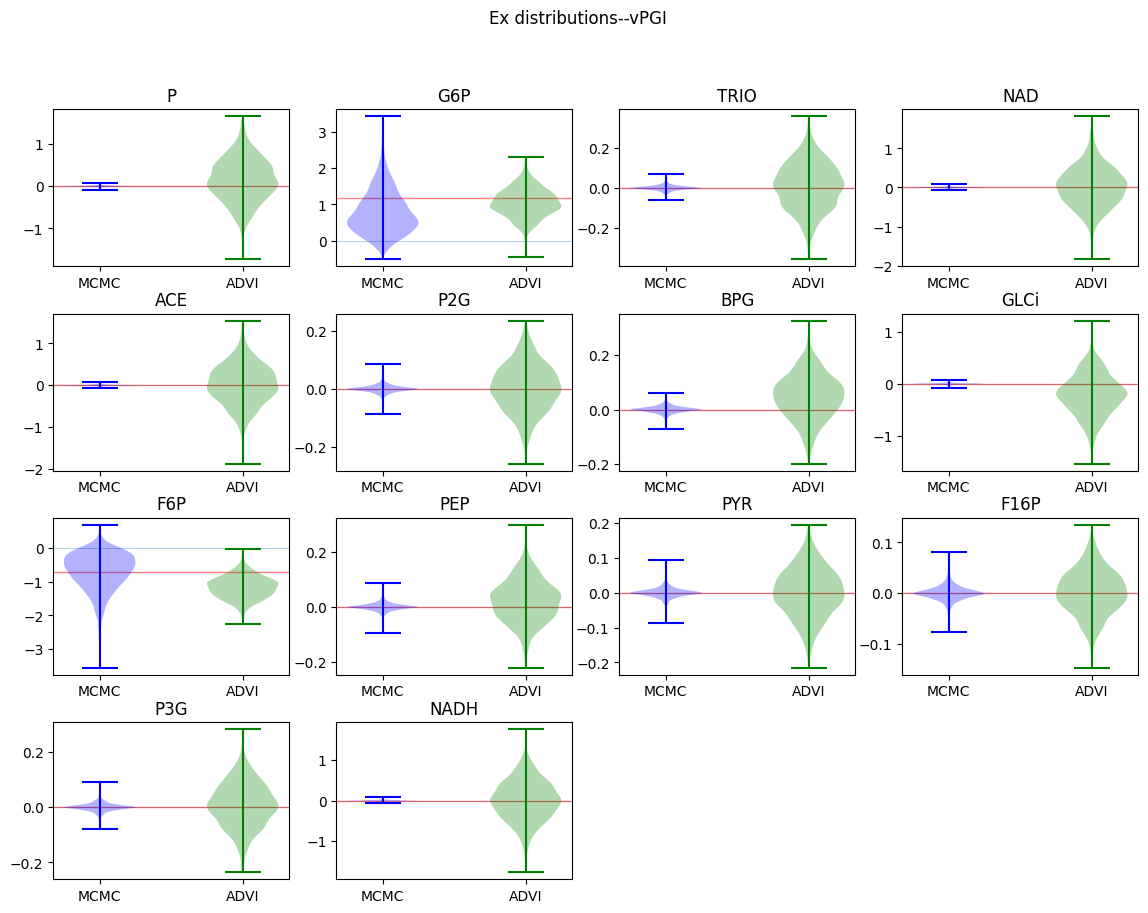

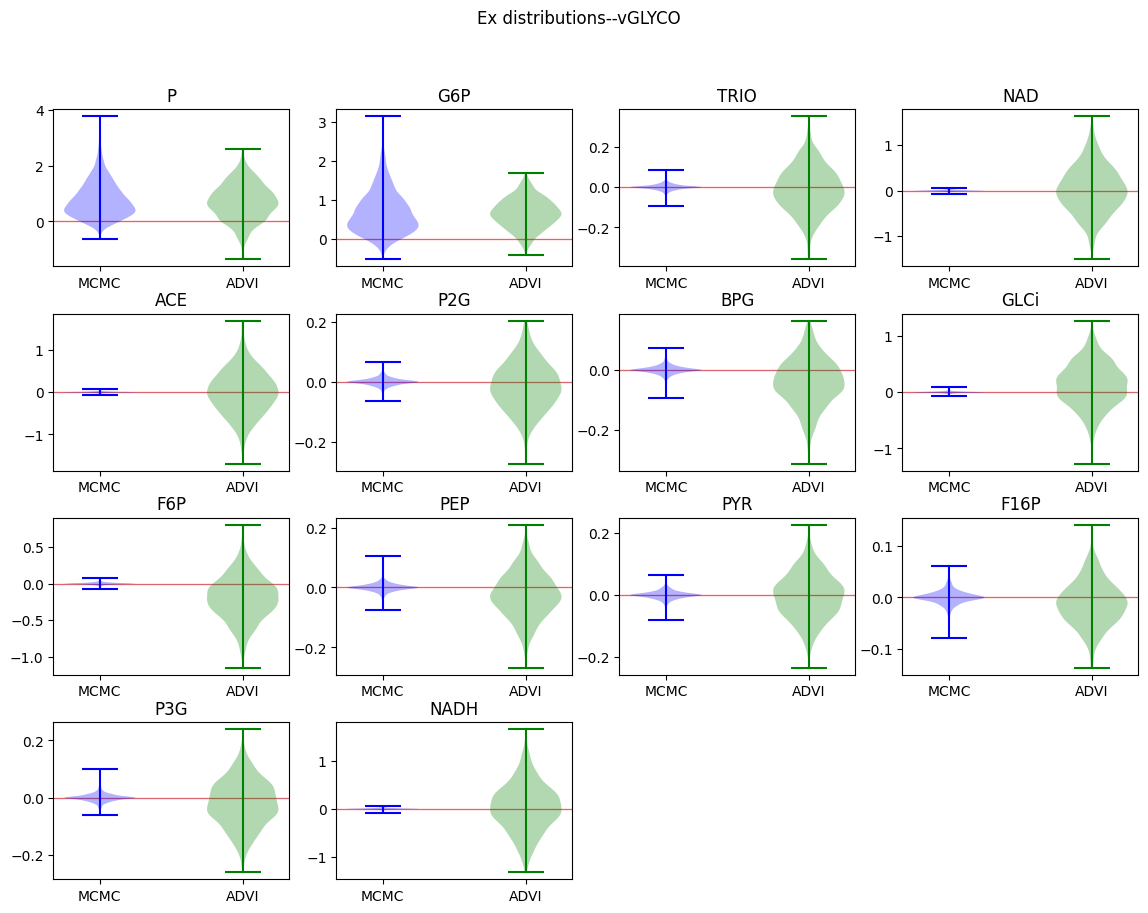

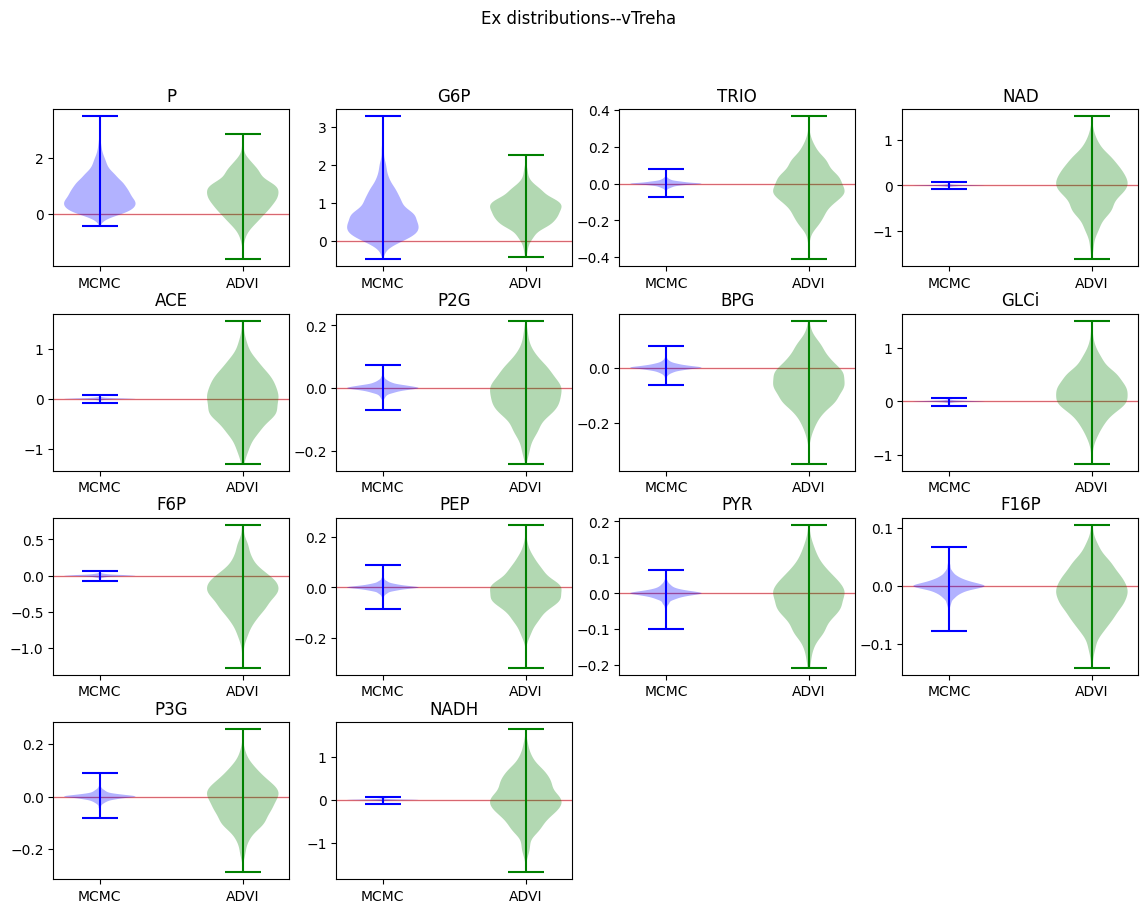

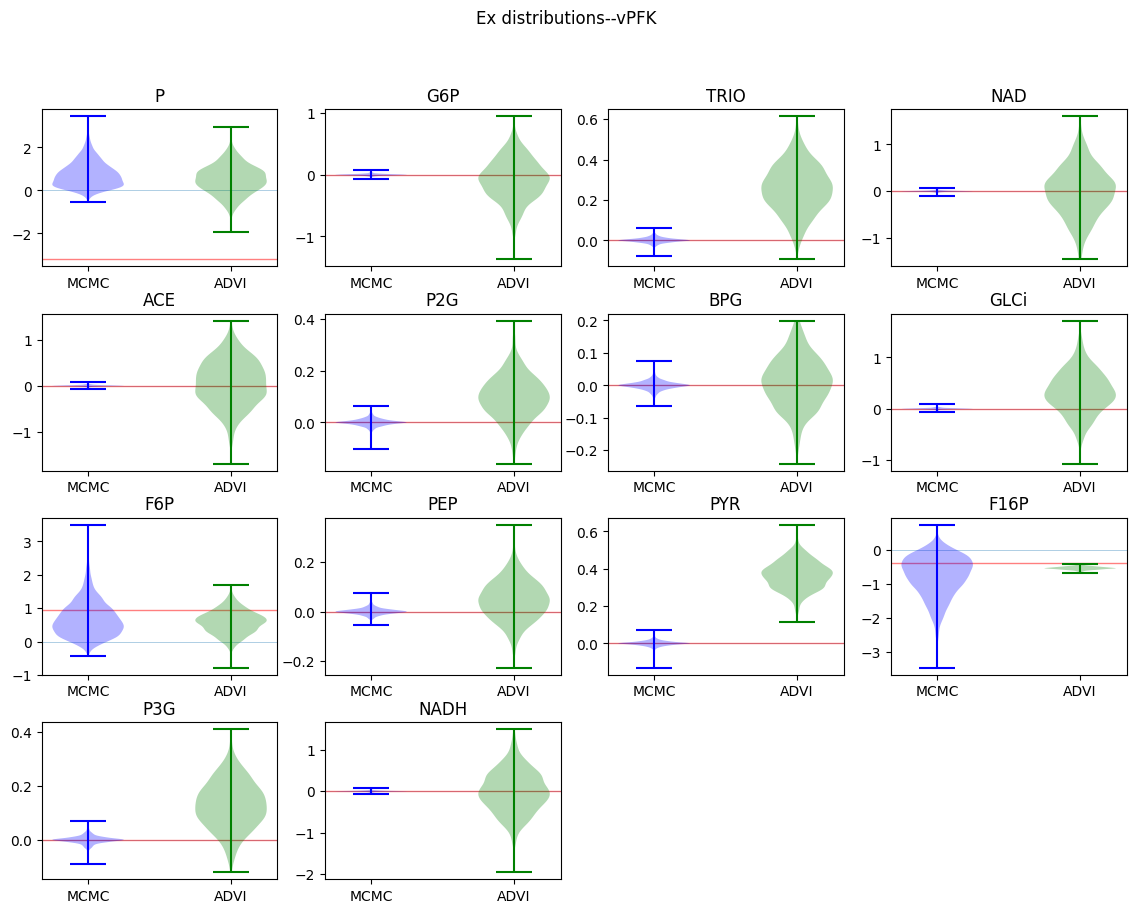

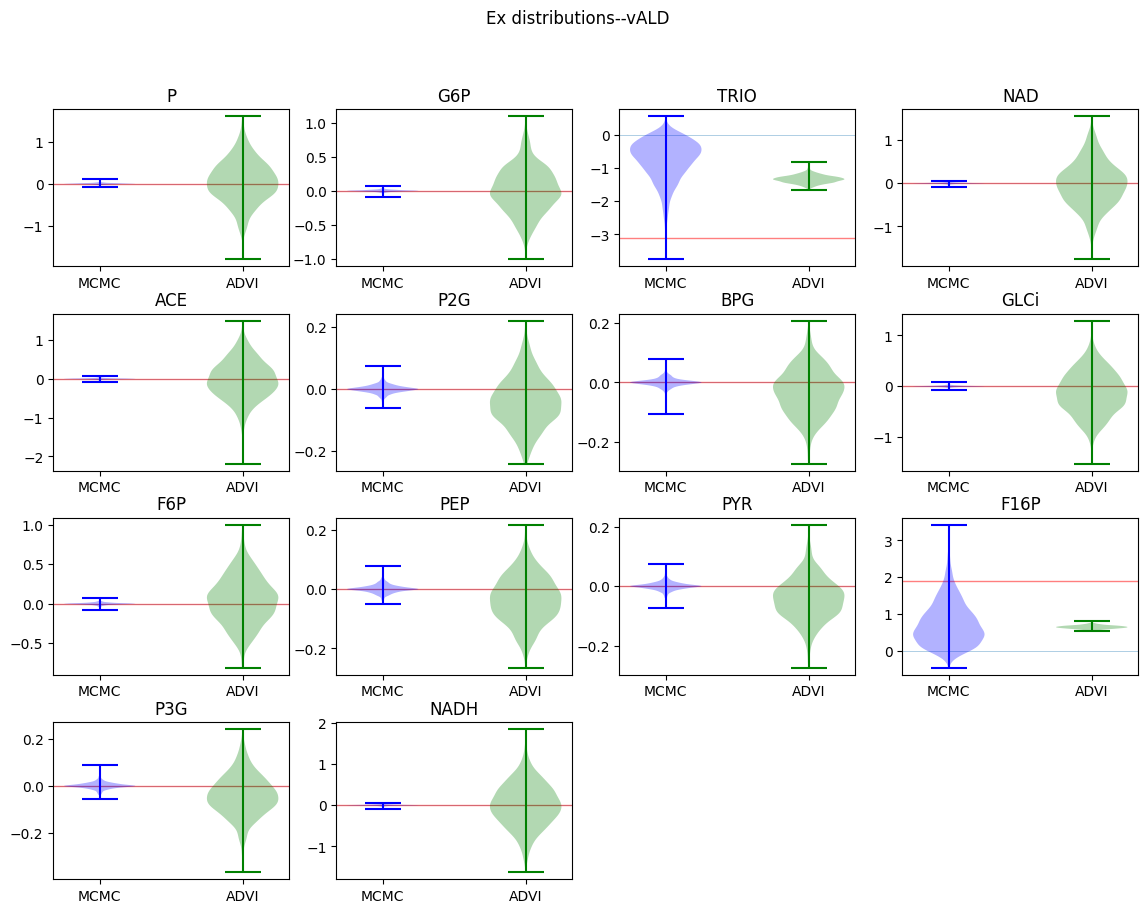

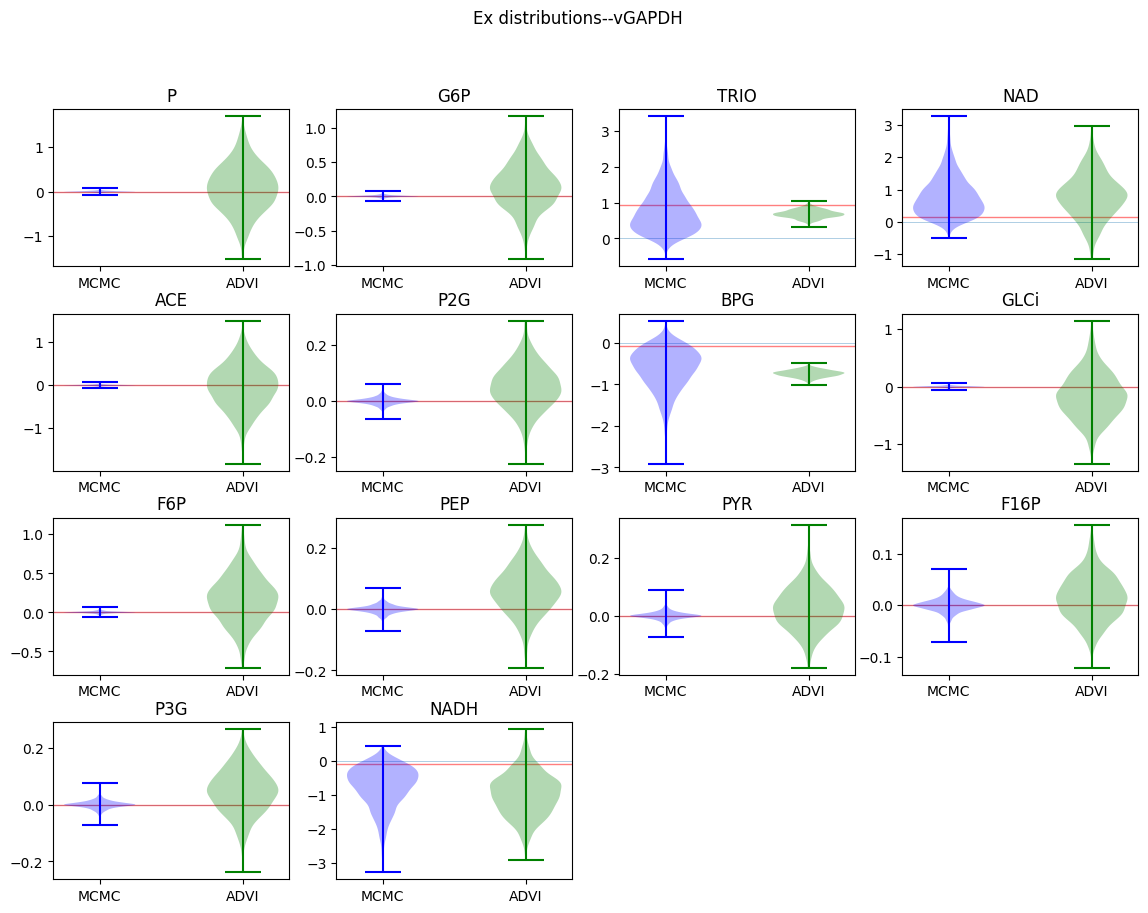

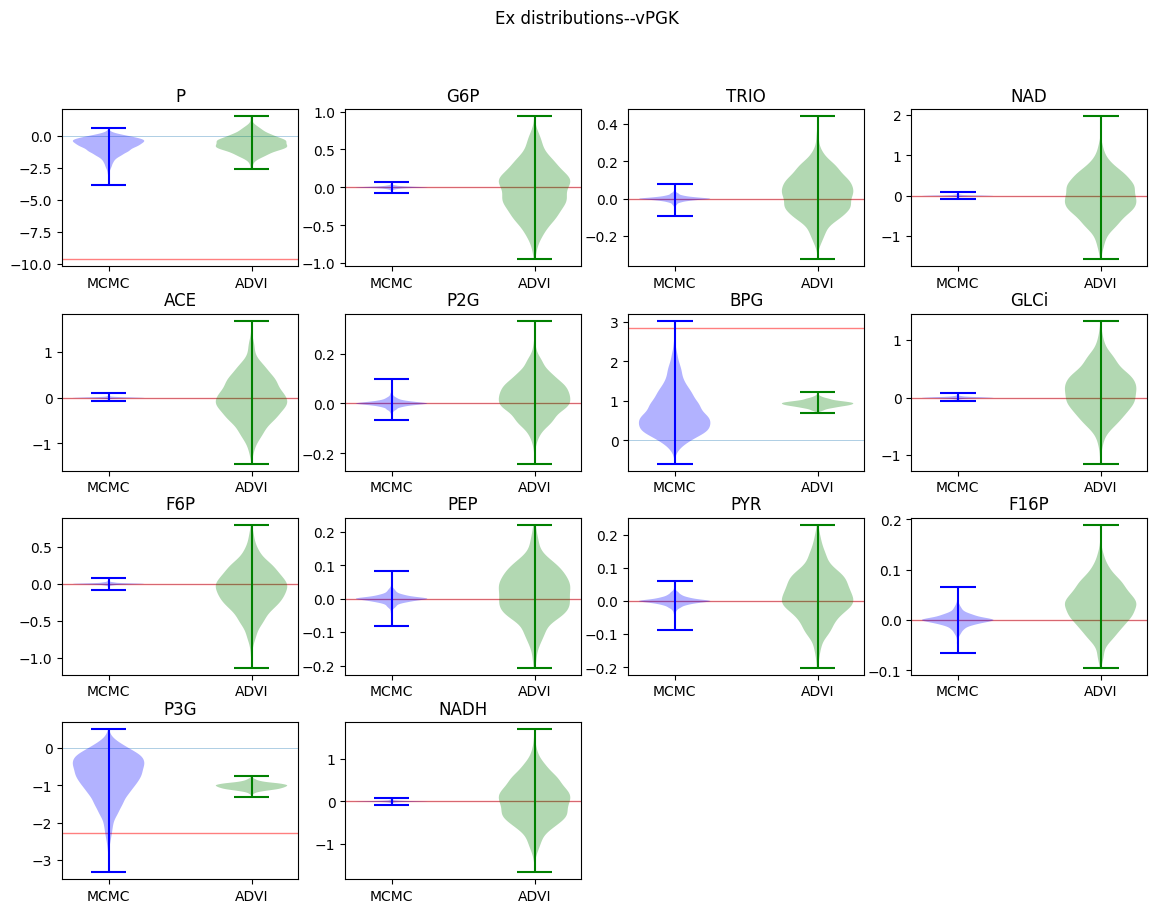

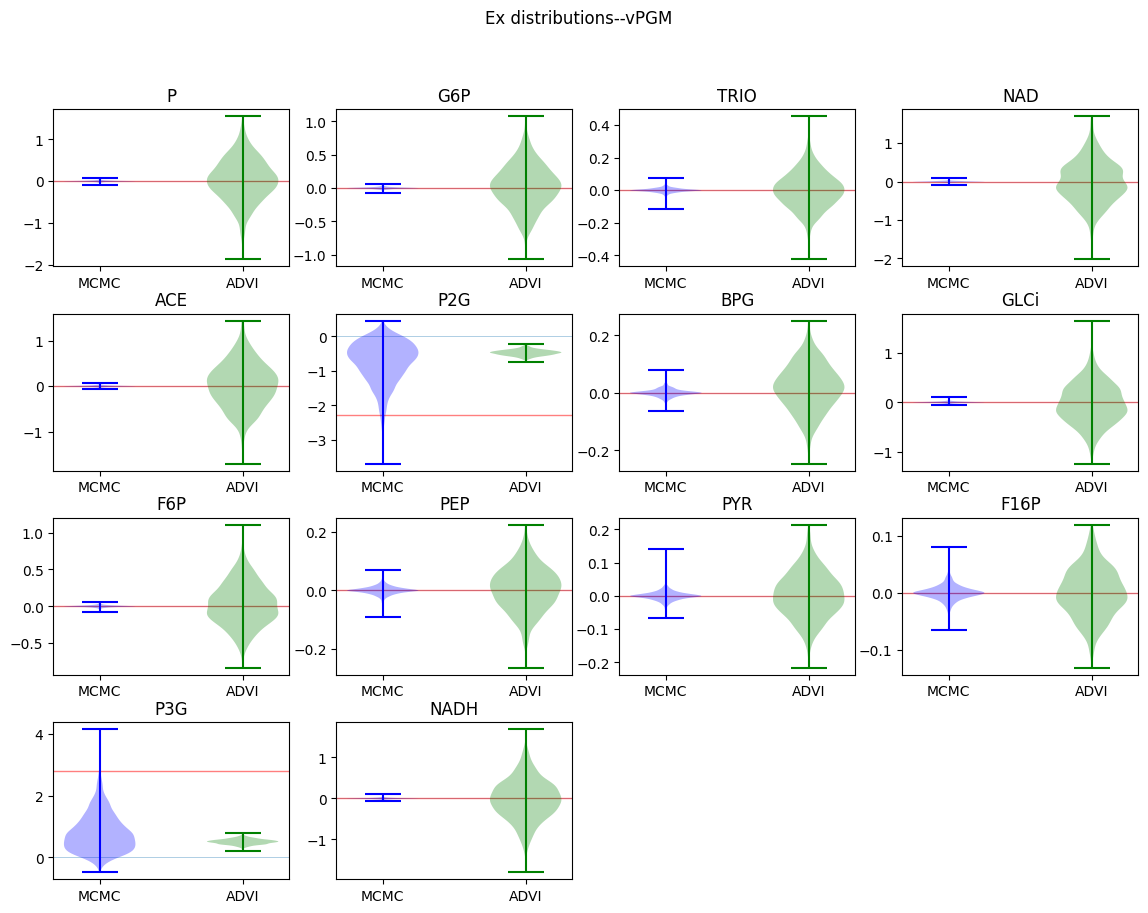

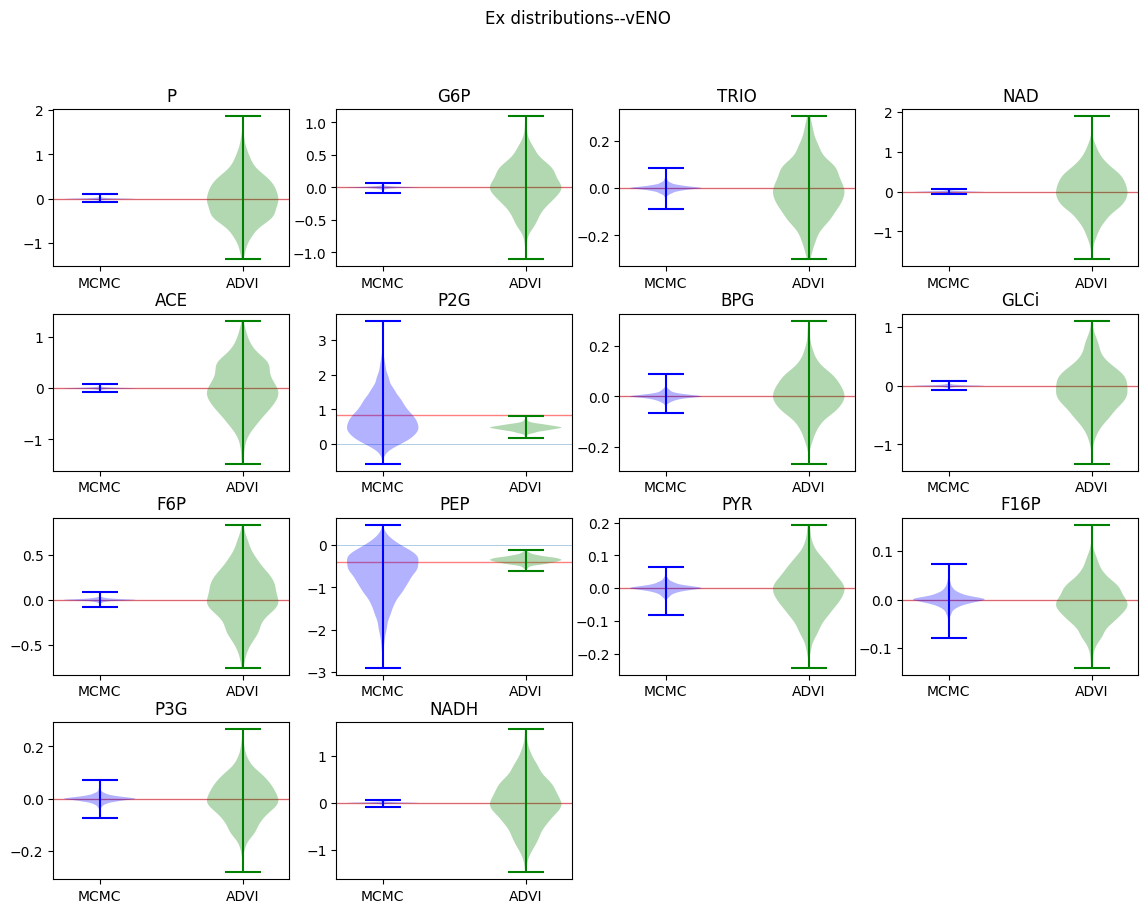

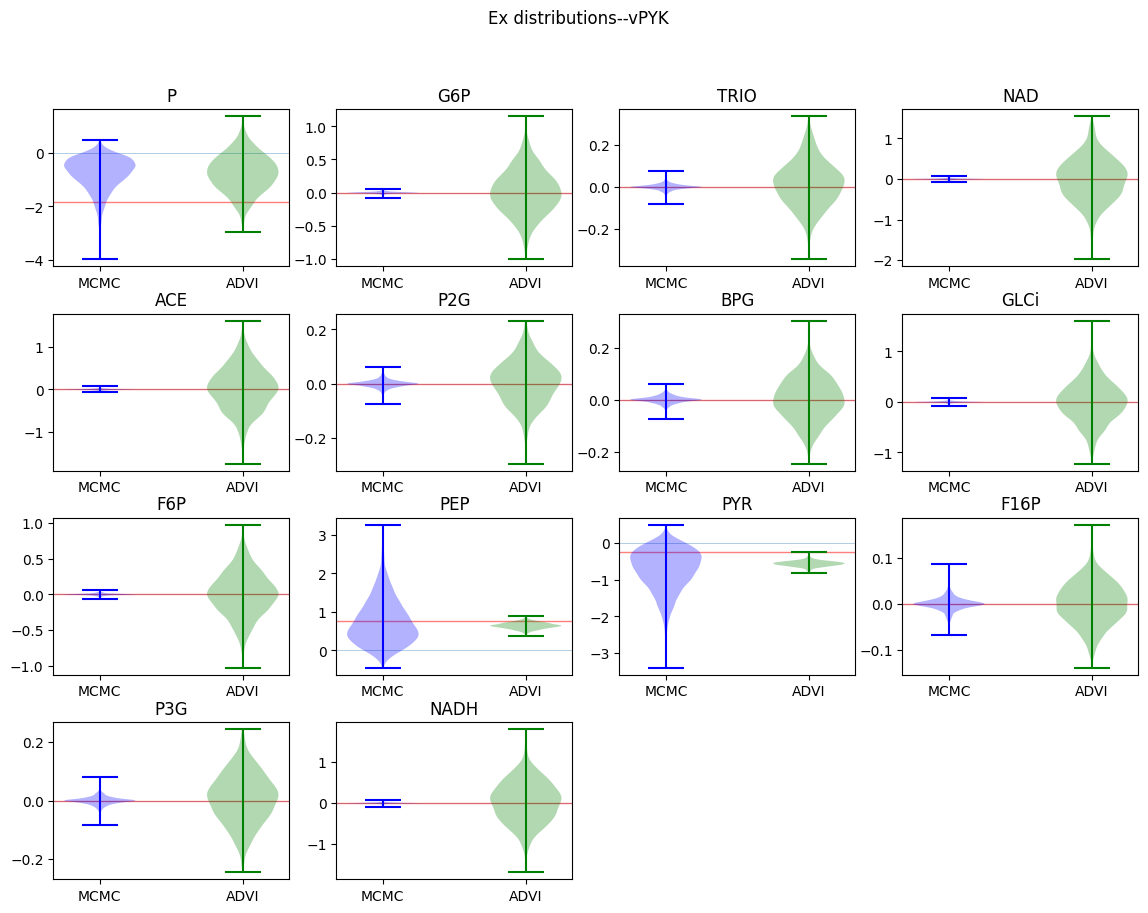

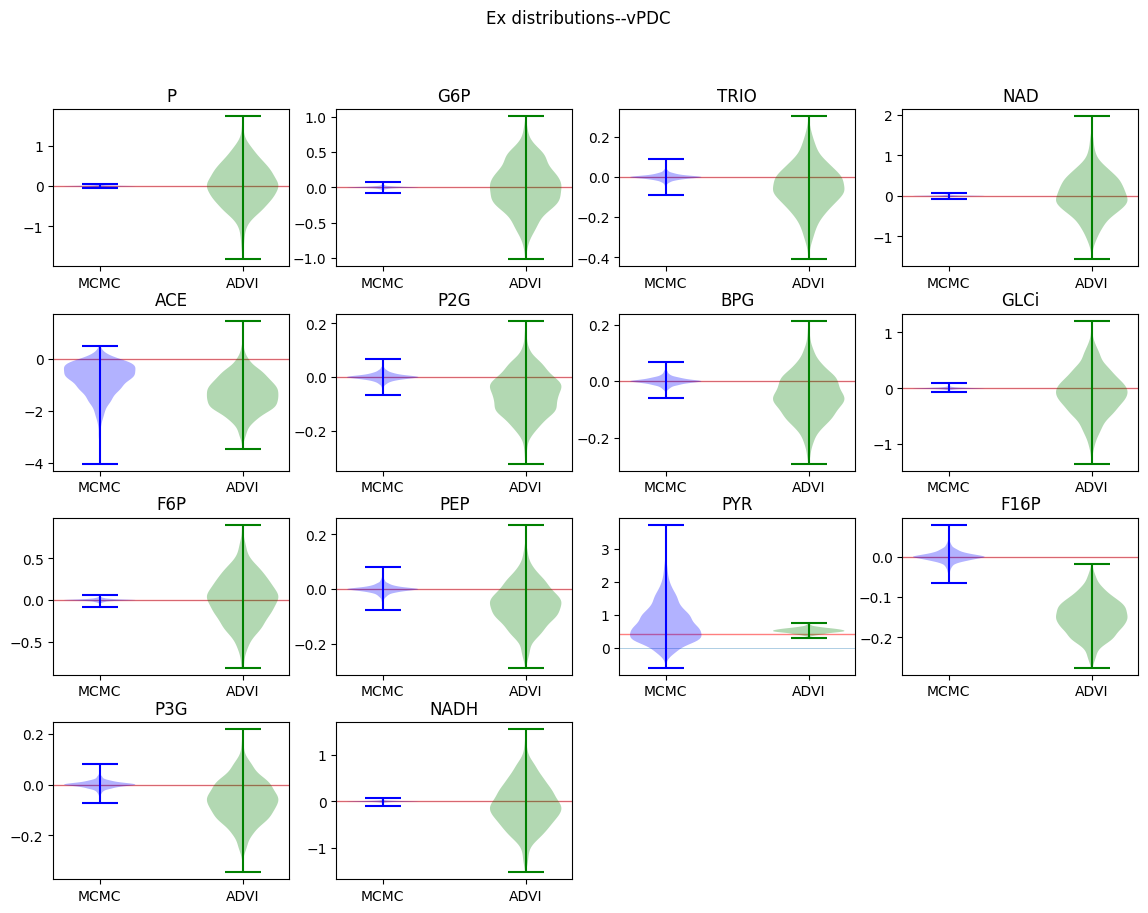

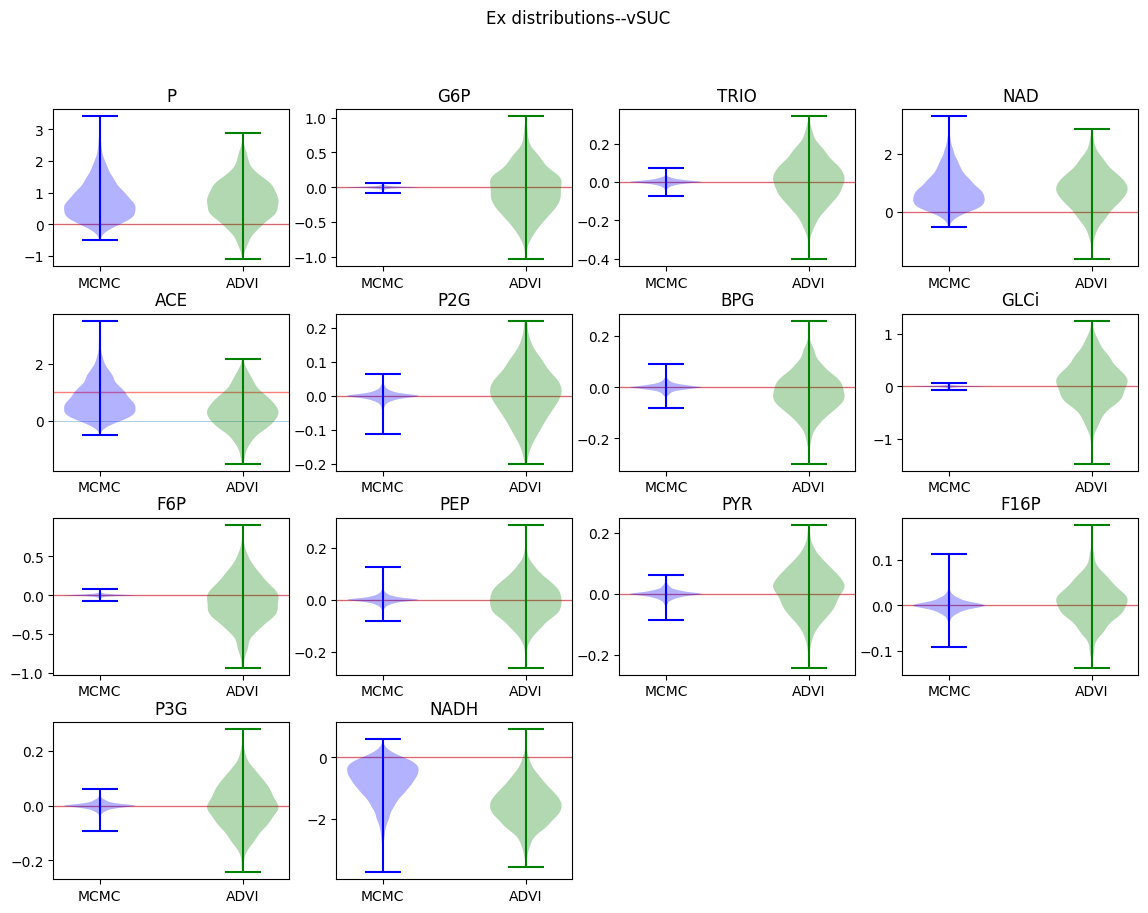

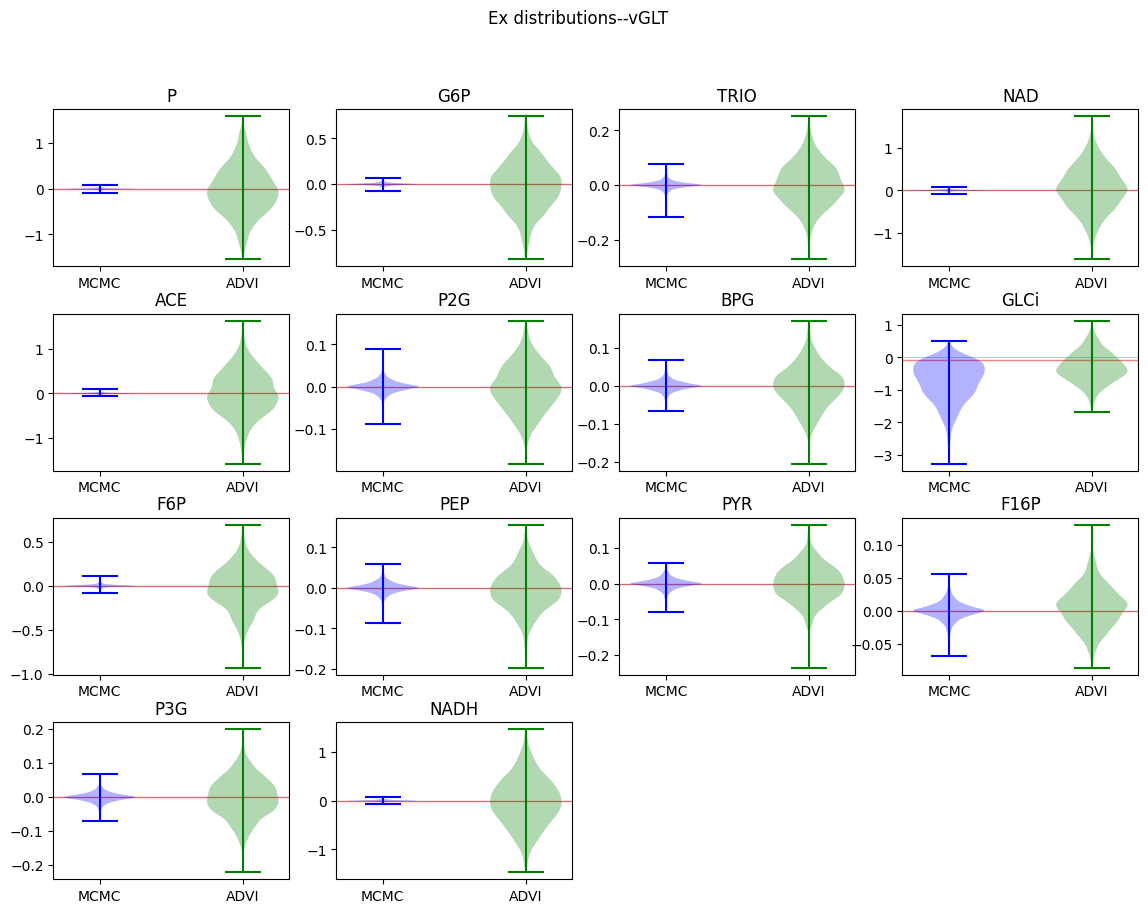

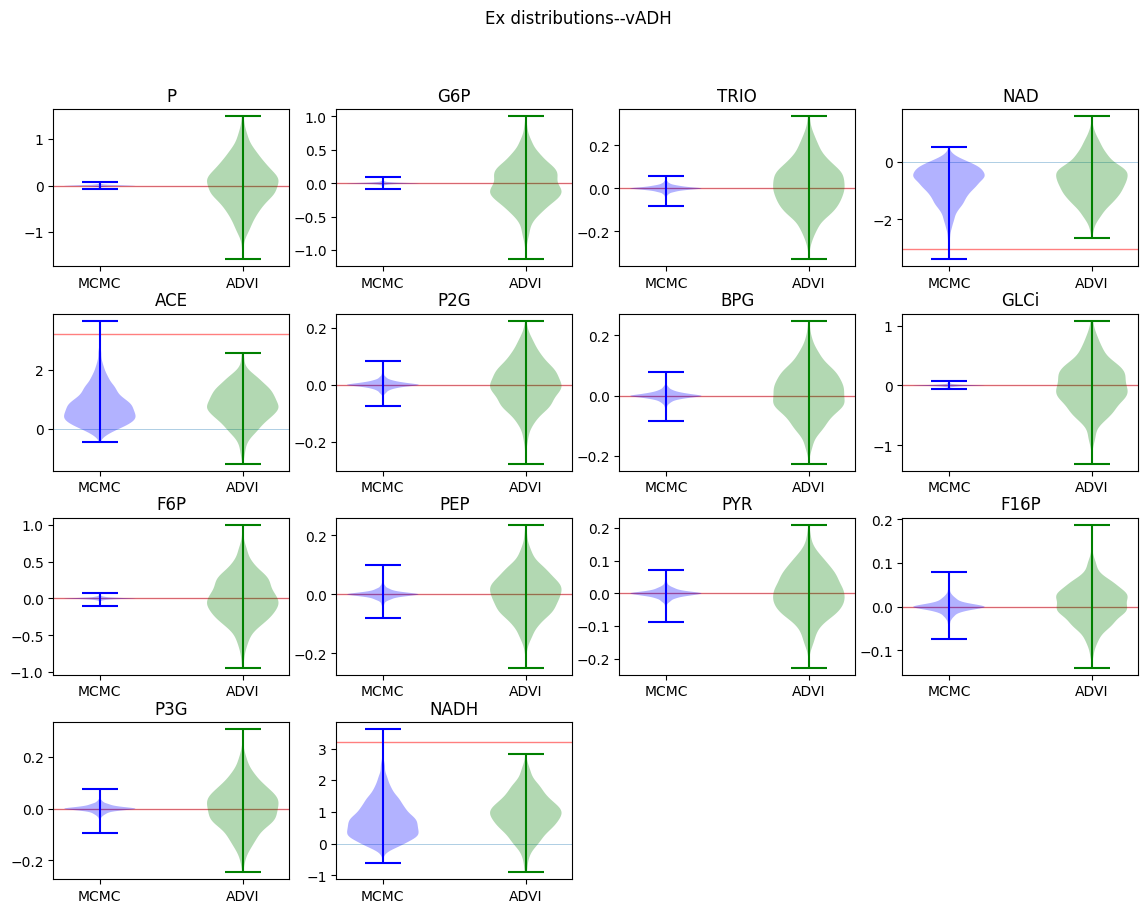

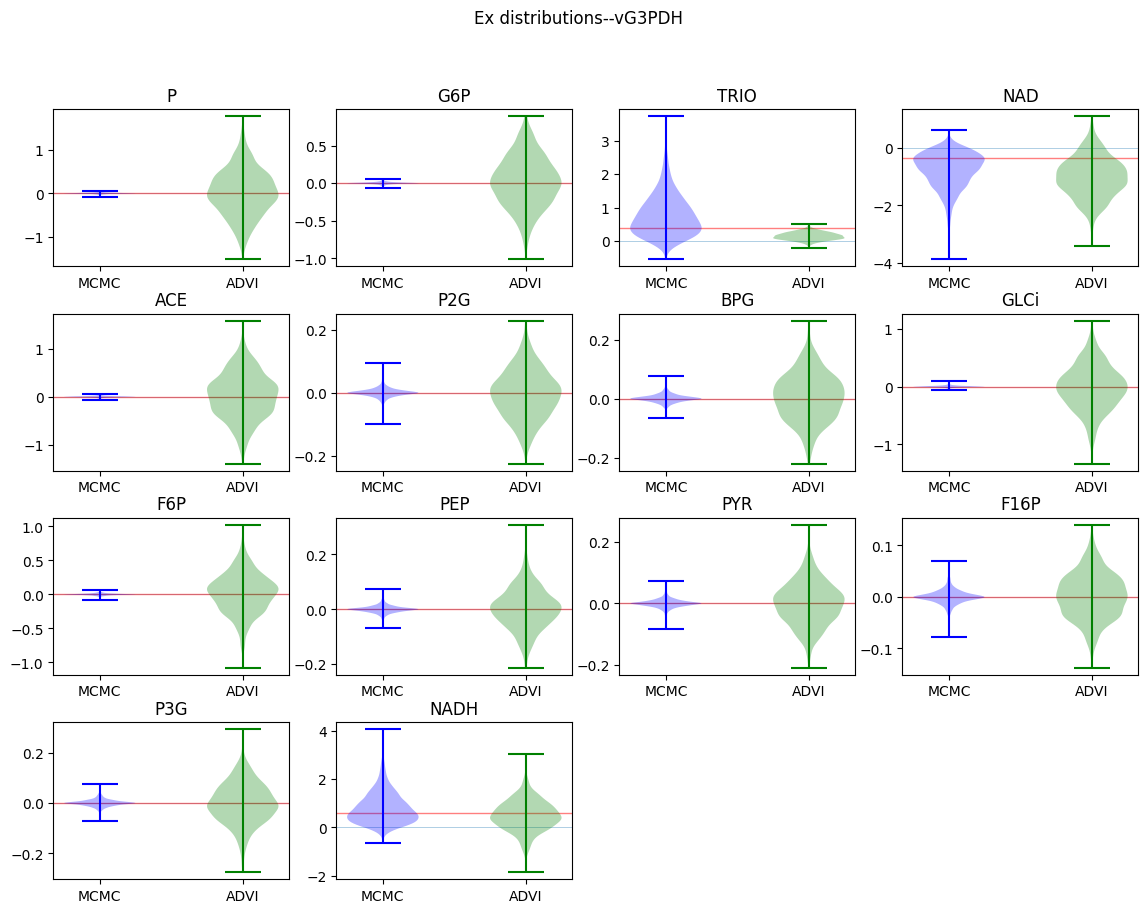

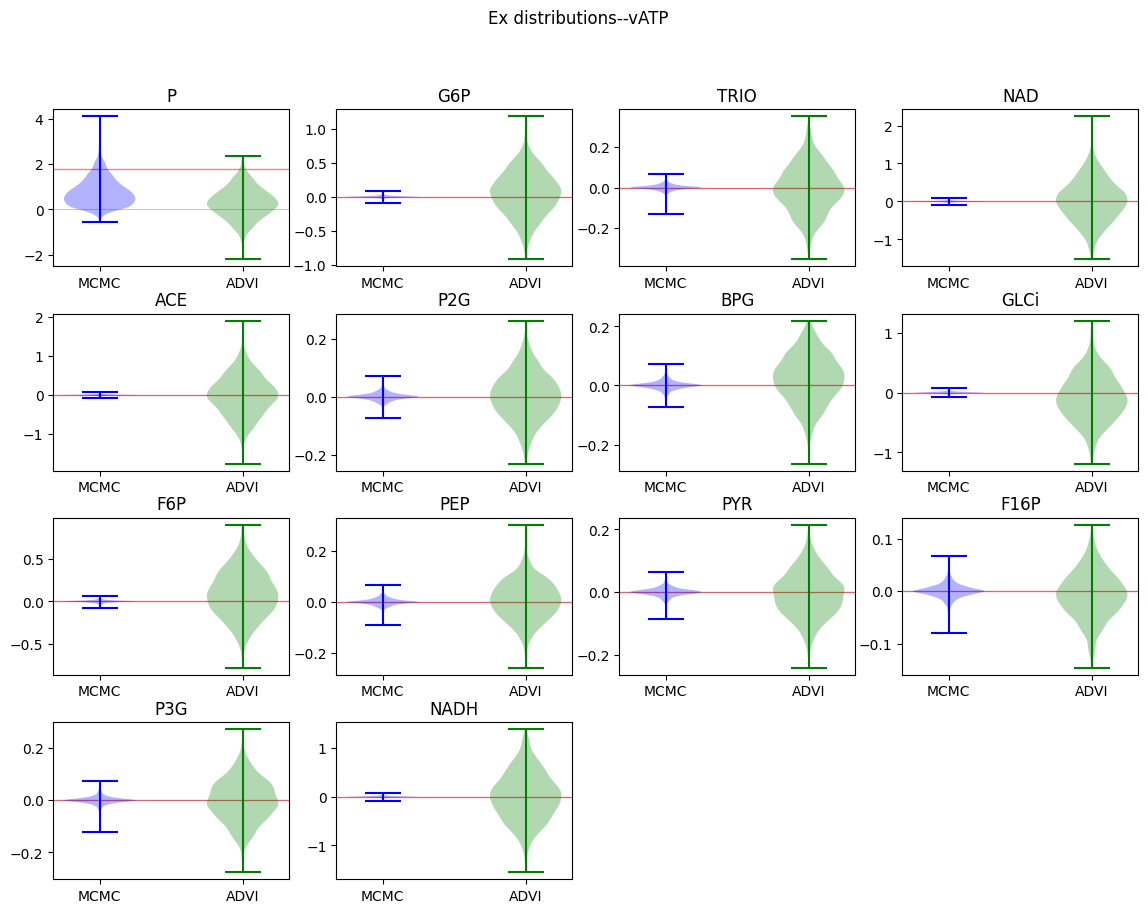

In [27]:
colors = ['blue', 'green', '#fa8602', 'magenta', '#07f53b', '#2312b8']

for i,rxn in enumerate(r.getReactionIds()): #['vADH']
    
    fig, ax = plt.subplots(4,4, figsize = (14,10))
    ii=-1
    
    fig.suptitle(f'Ex distributions--{rxn}\n')
    plt.setp(ax, xticks=range(3), xticklabels=[0,'MCMC', 'ADVI'])
    plt.subplots_adjust(hspace=0.3)
    
    for j,met in enumerate(r.getFloatingSpeciesIds()): # ['TRIO'])
        if j%4==0:
            ii += 1

        met_traces=[]
        for trace in [Ex.transpose(1, 2, 0), Ex_advi.transpose(1,2,0)]: 
            met_traces.append(trace[i,j,:]) 
            
        met_traces = np.array(met_traces).T

        plots = ax[ii, j%4].violinplot(met_traces)

        # Set the color of the violin patches
        for pc, color in zip(plots['bodies'], colors):
            pc.set_facecolor(color)
        plots['cbars'].set_colors(colors)
        plots['cmaxes'].set_colors(colors)
        plots['cmins'].set_colors(colors)
        
        ax[ii, j%4].axhline(0, linewidth=0.5, zorder=0, alpha=0.5)
        ax[ii, j%4].axhline(r.getScaledElasticityMatrix()[i,j], linewidth=1, zorder=0, alpha=0.5,color='red')
        ax[ii, j%4].set_title(met)
    
    fig.delaxes(ax[3,2]) 
    fig.delaxes(ax[3,3]) 

## Backcalculating to check if there are multiple elasticity solutions

In [28]:
med_Ex = np.median(Ex, axis=0)
med_Ey = np.median(Ey, axis=0)
med_Ex_advi = np.median(Ex_advi, axis=0)
med_Ey_advi = np.median(Ey_advi, axis=0)

In [29]:
BMCA_obj.vn
# d_df is the flux calculated using the Bayesian inference MCMC POSTERIORS for elasticity
MCMC_vn = BMCA_obj.en.values * (np.ones(BMCA_obj.en.T.shape) + med_Ex@(BMCA_obj.xn.T) + med_Ey@(BMCA_obj.yn.T)).T
MCMC_vn_df = pd.DataFrame(MCMC_vn)
MCMC_vn_df.columns = BMCA_obj.vn.columns #r.getReactionIds()
MCMC_vn_df

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007515,1.000876,0.994740,0.994683,0.997127,0.998140,1.003440,0.998427,0.999960,1.000601,0.999075,0.997603,0.998135,0.985317,0.999577,0.998266,0.998980
2,0.995065,0.995811,1.004865,1.004939,0.999960,0.999971,1.000050,0.999980,0.999999,1.000008,0.999987,0.999967,0.999972,0.999793,0.999997,0.999975,0.999984
3,0.995625,0.998950,0.994418,1.004502,1.003551,1.001158,0.996545,1.001866,0.999958,0.999131,1.001215,1.001299,1.001644,1.001985,1.000235,1.001108,1.001090
4,0.996867,0.999285,1.003192,0.993189,1.002412,1.000877,0.997592,1.001272,0.999979,0.999420,1.000819,1.001014,1.001169,1.001370,1.000182,1.000835,1.000755
5,0.996237,0.997867,1.003712,1.003768,0.996486,0.999980,1.000042,0.999986,1.000001,1.000005,0.999992,0.999975,0.999979,0.999844,1.000000,0.999980,0.999989
6,0.999204,0.999545,1.000786,1.000796,0.997699,0.993438,1.000009,0.999996,1.000001,1.000002,0.999999,0.999996,0.999994,0.999968,1.000000,0.999994,0.999998
7,0.999385,0.999209,1.000527,1.000547,0.990518,1.004037,1.000585,0.998926,1.000037,1.000521,0.999291,0.997711,1.002586,0.998759,0.999856,1.004777,0.999381
8,0.999983,0.999978,1.000015,1.000015,0.999729,1.000115,0.998361,0.992151,1.000001,1.000015,0.999979,0.999934,1.000075,0.999964,0.999995,1.000136,0.999983
9,0.999986,0.999982,1.000012,1.000012,0.999779,1.000095,0.998660,0.999303,0.992502,1.000012,0.999982,0.999946,1.000062,0.999970,0.999995,1.000112,0.999986


In [30]:
BMCA_obj.vn
# d_df is the flux calculated using the Bayesian inference ADVI POSTERIORS for elasticity
advi_vn = BMCA_obj.en.values * (np.ones(BMCA_obj.en.T.shape) + med_Ex_advi@(BMCA_obj.xn.T) + med_Ey_advi@(BMCA_obj.yn.T)).T
advi_vn_df = pd.DataFrame(advi_vn)
advi_vn_df.columns = BMCA_obj.vn.columns #r.getReactionIds()
advi_vn_df

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998217,0.998201,1.000042,0.999280,0.999605,0.998258,0.997793,0.999475,0.998352,0.998185,0.998904,0.999543,1.000533,0.993145,0.999374,0.998835,0.996059
2,0.992836,0.998698,1.005483,1.006994,0.999373,0.999946,1.001026,0.999828,1.000229,1.000103,0.999940,0.999987,0.999533,0.999753,0.999713,1.000043,1.000477
3,0.997714,0.997940,0.992132,1.002946,1.005155,0.999688,0.998582,1.002904,1.000677,1.000385,1.001412,0.999039,1.000573,1.000521,1.000222,1.000614,1.001911
4,0.998317,0.998564,1.001547,0.992104,1.003707,0.999751,0.999064,1.001987,1.000487,1.000299,1.000980,0.999318,1.000403,1.000349,1.000173,1.000446,1.001348
5,0.996013,0.994175,1.002108,1.003127,0.995878,1.000468,1.002631,0.999229,1.000366,1.000504,1.000031,1.000193,0.998831,0.999484,0.999631,1.000384,1.001181
6,0.999260,0.998776,1.000380,1.000600,0.998393,0.993515,1.000634,0.999993,1.000072,1.000074,1.000021,0.999248,0.999794,0.999926,0.999961,1.000095,1.000215
7,0.998414,0.997319,1.000146,1.000518,0.995124,0.997422,1.002668,0.998429,1.000049,0.999899,0.999406,0.994226,1.003865,0.999436,0.999461,1.000342,0.999630
8,1.000066,1.000102,0.999866,0.999821,0.999898,0.999824,0.997764,0.993203,1.000074,1.000026,0.999987,0.999639,1.000036,0.999979,1.000014,1.000033,1.000075
9,1.000134,1.000109,0.999817,0.999830,1.000375,0.999704,0.998349,0.998972,0.991876,1.000014,1.000025,0.999484,1.000037,0.999977,1.000031,1.000009,1.000055


Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

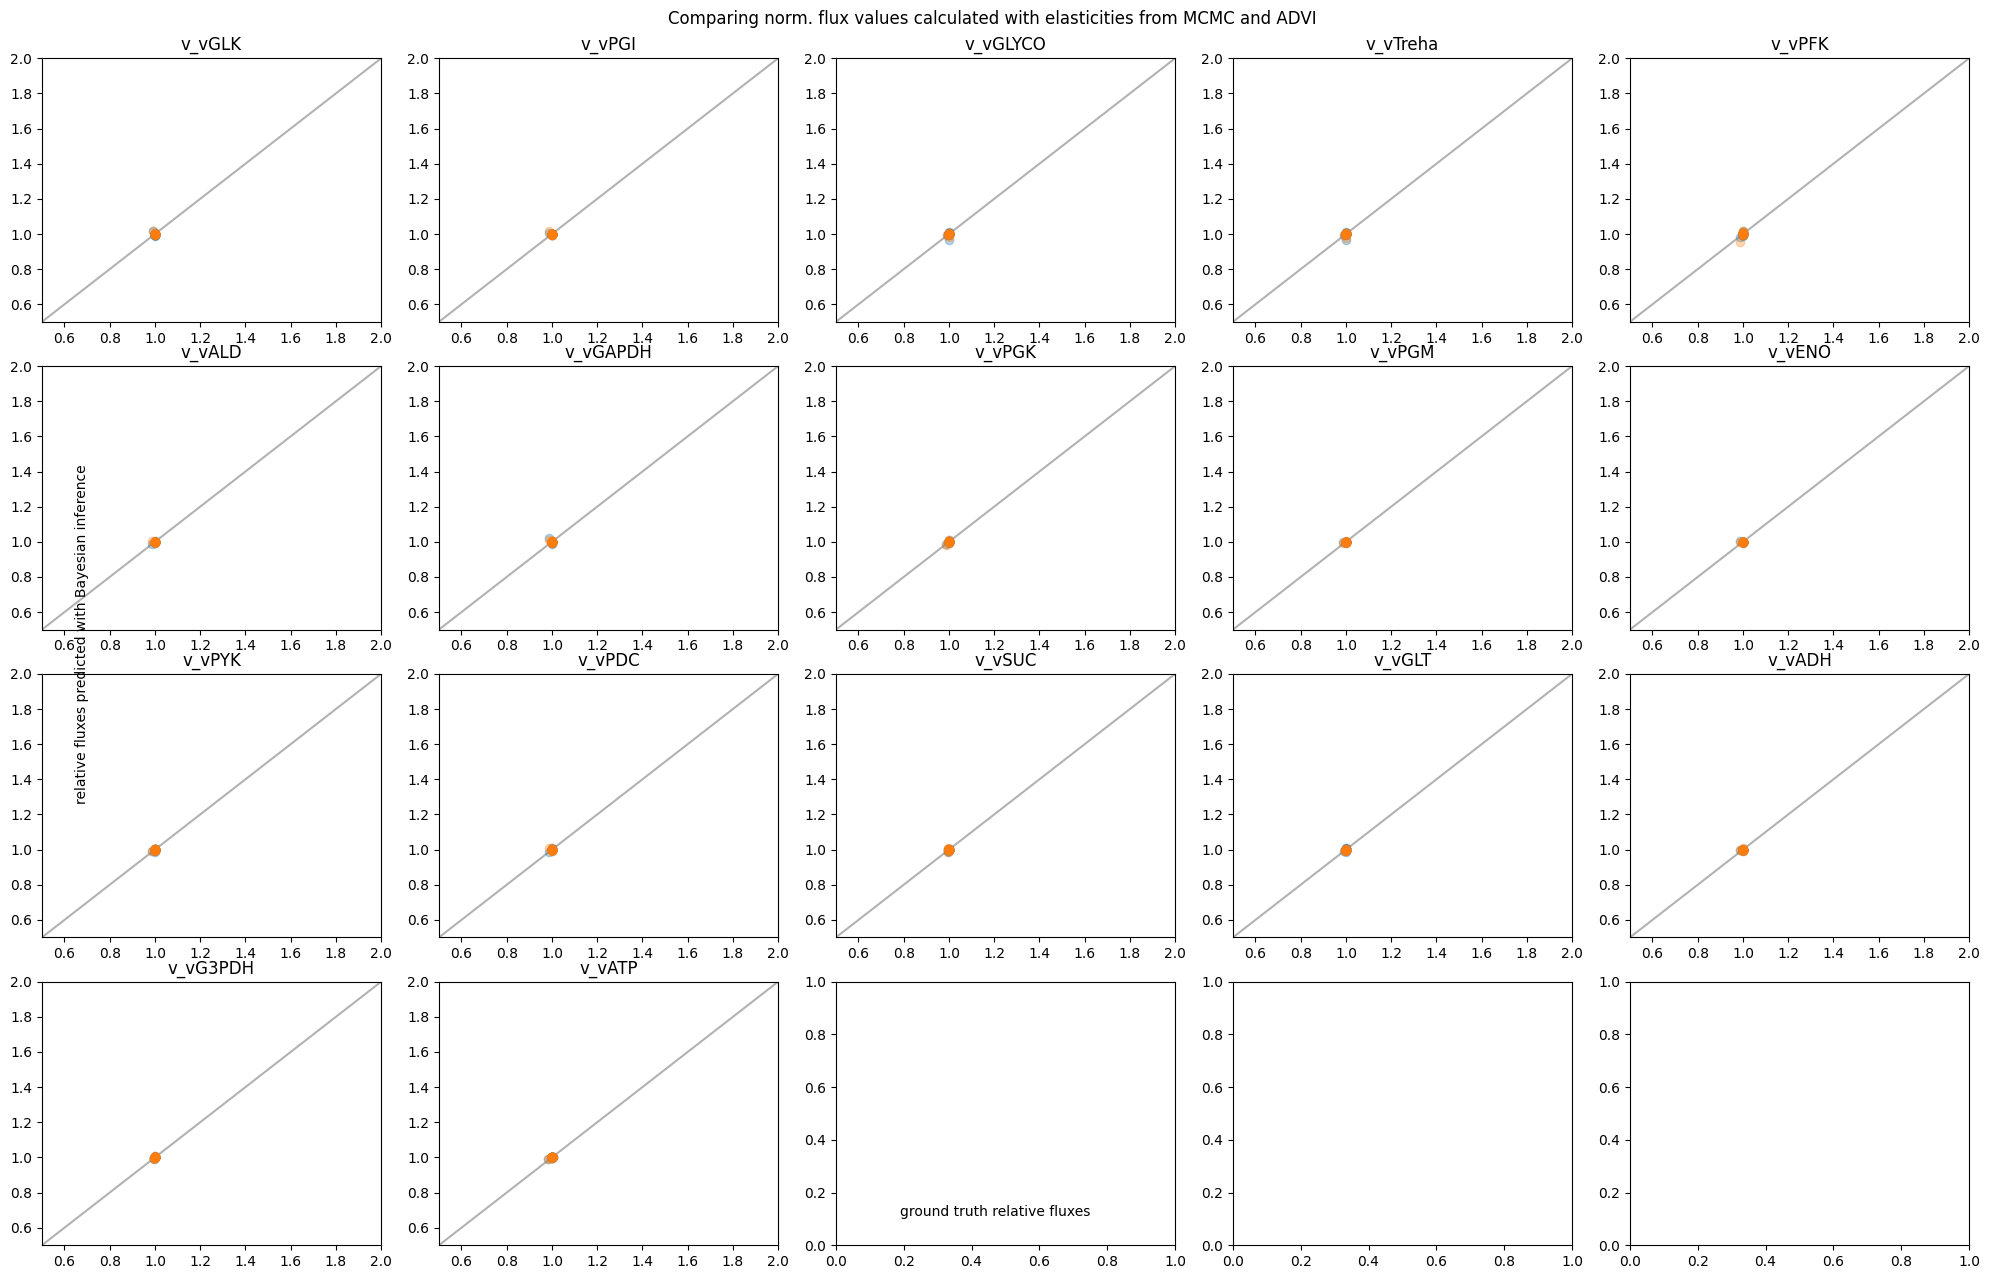

In [31]:
fig, axs = plt.subplots(4,5, figsize=(20, 13)) 
idx_starter = -1

fig.suptitle('Comparing norm. flux values calculated with elasticities from MCMC and ADVI \n')
fig.tight_layout()

lims = [0.5,2]

for i,col in enumerate(MCMC_vn_df.columns):
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(BMCA_obj.vn[col], MCMC_vn_df[col], alpha=0.3)
    axs[idx_starter, i%5].scatter(BMCA_obj.vn[col], advi_vn_df[col], alpha=0.3)
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

### Subtracting the vn values from fluxes calculated using elasticity posteriors

In [32]:
mcmc_dif = MCMC_vn_df-BMCA_obj.vn
# mcmc_dif[mcmc_dif < 1E-3] = 0 
mcmc_dif

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
1,9.102818e-03,2.685418e-03,-0.005260,-5.316735e-03,-0.001064,-5.028457e-05,0.005364,3.512165e-04,1.884236e-03,2.525275e-03,0.001000,-4.722033e-04,-9.174415e-04,-1.309459e-02,1.557272e-03,-7.864325e-04,0.001721
2,-4.913208e-03,-4.163855e-03,0.004865,4.938993e-03,-0.000015,-3.658967e-06,0.000077,6.605463e-06,2.556621e-05,3.435748e-05,0.000014,-6.378537e-06,-1.454355e-05,-1.846341e-04,2.503157e-05,-1.171107e-05,0.000022
3,-4.587553e-03,-2.067573e-03,0.004418,4.501895e-03,0.002533,1.405183e-04,-0.004529,7.921182e-04,-1.116497e-03,-1.943268e-03,0.000141,2.244129e-04,1.047673e-03,1.772025e-03,-8.660141e-04,5.119524e-04,-0.001832
4,-3.279686e-03,-1.503100e-03,0.003192,3.188564e-03,0.001624,8.918950e-05,-0.003241,4.394336e-04,-8.542147e-04,-1.413075e-03,-0.000014,1.815641e-04,7.185454e-04,1.223037e-03,-6.720861e-04,3.845504e-04,-0.001267
5,-3.746286e-03,-2.113728e-03,0.003712,3.768104e-03,-0.003495,-8.689745e-07,0.000062,6.765454e-06,2.096386e-05,2.583205e-05,0.000012,-4.972562e-06,-1.091446e-05,-1.390420e-04,2.129289e-05,-1.029061e-05,0.000018
6,-7.927735e-04,-4.507887e-04,0.000786,7.963492e-04,-0.002297,-6.558145e-03,0.000013,5.856050e-07,5.242442e-06,6.074660e-06,0.000003,-1.091300e-08,-3.532237e-06,-2.825495e-05,4.568713e-06,-3.470169e-06,0.000004
7,-4.816694e-04,-6.383332e-04,0.000527,5.468779e-04,-0.009330,4.188997e-03,0.001064,-5.950639e-04,5.155455e-04,9.999916e-04,-0.000230,-1.810146e-03,2.888189e-04,-1.107530e-03,4.914598e-04,2.479988e-03,0.001044
8,-1.348004e-05,-1.761015e-05,0.000015,1.533532e-05,-0.000267,1.197104e-04,-0.001626,-7.835426e-03,1.447532e-05,2.893498e-05,-0.000007,-5.224719e-05,9.198629e-06,-3.237468e-05,1.356201e-05,6.994959e-05,0.000031
9,-1.132930e-05,-1.453954e-05,0.000012,1.246183e-05,-0.000218,9.829920e-05,-0.001329,-6.862793e-04,-7.487262e-03,2.341017e-05,-0.000006,-4.311491e-05,7.865928e-06,-2.725567e-05,1.025065e-05,5.784447e-05,0.000025


In [33]:
advi_dif = advi_vn_df-BMCA_obj.vn
advi_dif[advi_dif < 1E-1] = 0 
advi_dif

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Will the fitting be better if perturbations are smaller?

In [34]:
BIOMD64_99 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_0.99.csv')
BIOMD64_09 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme0.9perts.csv')

Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

../../data/interim/Antimony/BIOMD0000000064_e_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

../../data/interim/Antimony/BIOMD0000000064_e_cobra.ant


In [35]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64_09.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64_09.Ey.to_numpy(), name='Ey'))
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BIOMD64_09.en.T)
    pm.Deterministic('en', e_obs)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64_09.xn.T)
    pm.Deterministic('chin', chi_obs)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64_09.yn.T)
    pm.Deterministic('yn', y_obs)
    likelihood = pm.Deterministic('vn', e_obs * (np.ones(BIOMD64_09.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64_09.vn.squeeze().T)
    pm.Deterministic('v_hat', v_hat_obs)

    trace_09 = pm.sample(1000, random_seed=1, cores=4)
    trace_99 = pm.sample(1000, random_seed=1, cores=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: Ru

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4284 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value enco

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4280 seconds.


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,789


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,748.1


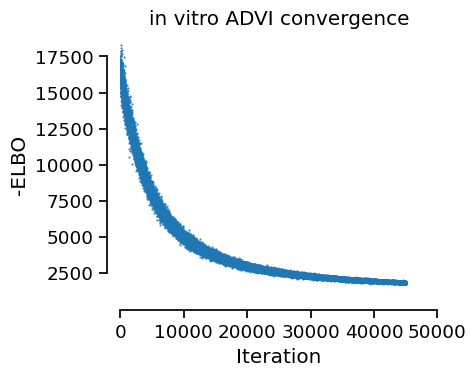

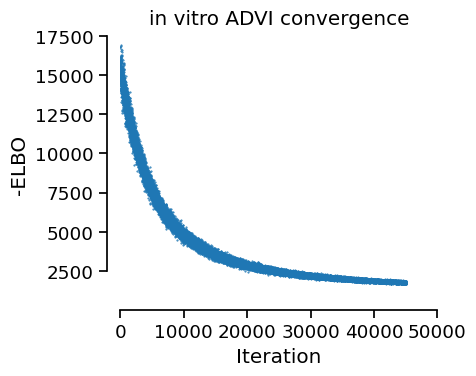

In [36]:
trace_ADVI_09 = run_ADVI(BIOMD64_09)
trace_ADVI_99 = run_ADVI(BIOMD64_99)

In [37]:
Ex_09 = (trace_09['posterior']['Ex']).to_numpy()
Ey_09 = (trace_09['posterior']['Ey']).to_numpy()

Ex_09 = reshape_elasticity(Ex_09)
Ey_09 = reshape_elasticity(Ey_09)

Ex_advi_09 = (trace_ADVI_09['posterior']['Ex']).to_numpy().squeeze()
Ey_advi_09 = (trace_ADVI_09['posterior']['Ey']).to_numpy().squeeze()

In [38]:
Ex_99 = (trace_99['posterior']['Ex']).to_numpy()
Ey_99 = (trace_99['posterior']['Ey']).to_numpy()

Ex_99 = reshape_elasticity(Ex_99)
Ey_99 = reshape_elasticity(Ey_99)

Ex_advi_99 = (trace_ADVI_99['posterior']['Ex']).to_numpy().squeeze()
Ey_advi_99 = (trace_ADVI_99['posterior']['Ey']).to_numpy().squeeze()

In [39]:
med_Ex_09 = np.median(Ex_09, axis=0)
med_Ey_09 = np.median(Ey_09, axis=0)
med_Ex_advi_09 = np.median(Ex_advi_09, axis=0)
med_Ey_advi_09 = np.median(Ey_advi_09, axis=0)
med_Ex_99 = np.median(Ex_99, axis=0)
med_Ey_99 = np.median(Ey_99, axis=0)
med_Ex_advi_99 = np.median(Ex_advi_99, axis=0)
med_Ey_advi_99 = np.median(Ey_advi_99, axis=0)

In [40]:
BIOMD64_09.vn
# flux calculated using the Bayesian inference MCMC POSTERIORS for elasticity
MCMC_vn_09 = BIOMD64_09.en.values * (np.ones(BIOMD64_09.en.T.shape) + med_Ex@(BIOMD64_09.xn.T) + med_Ey@(BIOMD64_09.yn.T)).T
MCMC_vn_df_09 = pd.DataFrame(MCMC_vn_09)
MCMC_vn_df_09.columns = BIOMD64_09.vn.columns #r.getReactionIds()
# MCMC_vn_df_09

In [41]:
# flux calculated using the Bayesian inference ADVI POSTERIORS for elasticity
advi_vn_09 = BMCA_obj.en.values * (np.ones(BIOMD64_09.en.T.shape) + med_Ex_advi@(BIOMD64_09.xn.T) + med_Ey_advi@(BIOMD64_09.yn.T)).T
advi_vn_df_09 = pd.DataFrame(advi_vn_09)
advi_vn_df_09.columns = BIOMD64_09.vn.columns #r.getReactionIds()
# advi_vn_df_09

Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

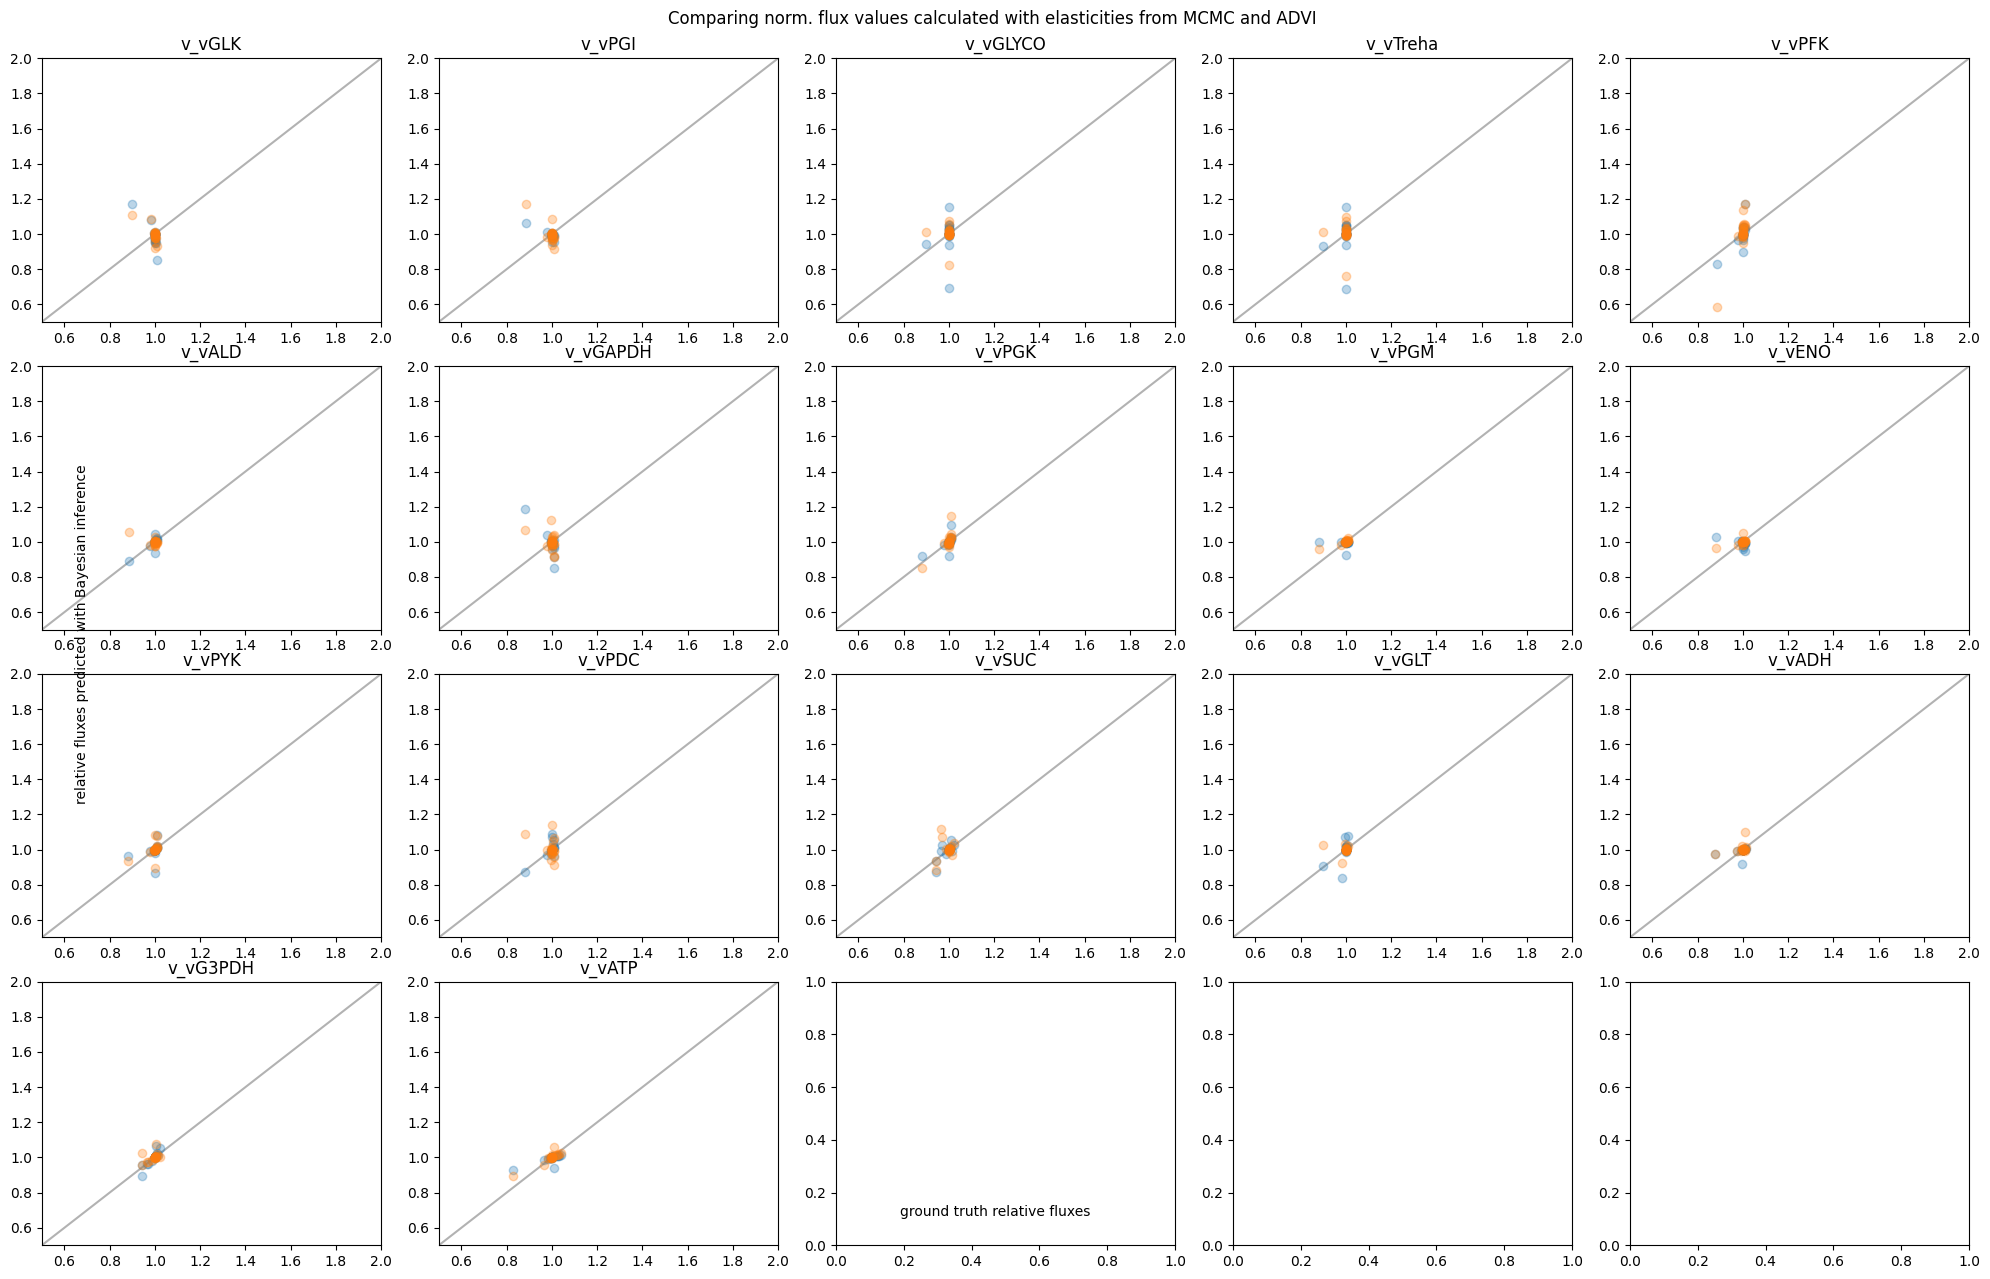

In [42]:
fig, axs = plt.subplots(4,5, figsize=(20, 13)) 
idx_starter = -1

fig.suptitle('Comparing norm. flux values calculated with elasticities from MCMC and ADVI \n')
fig.tight_layout()

lims = [0.5,2]

for i,col in enumerate(MCMC_vn_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(BIOMD64_09.vn[col], MCMC_vn_df_09[col], alpha=0.3)
    axs[idx_starter, i%5].scatter(BIOMD64_09.vn[col], advi_vn_df_09[col], alpha=0.3)
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

In [43]:
BIOMD64_99.vn
# flux calculated using the Bayesian inference MCMC POSTERIORS for elasticity
MCMC_vn_99 = BIOMD64_99.en.values * (np.ones(BIOMD64_99.en.T.shape) + med_Ex@(BIOMD64_99.xn.T) + med_Ey@(BIOMD64_99.yn.T)).T
MCMC_vn_df_99 = pd.DataFrame(MCMC_vn_99)
MCMC_vn_df_99.columns = BIOMD64_99.vn.columns #r.getReactionIds()
# MCMC_vn_df_99

In [44]:
# flux calculated using the Bayesian inference ADVI POSTERIORS for elasticity
advi_vn_99 = BMCA_obj.en.values * (np.ones(BIOMD64_99.en.T.shape) + med_Ex_advi@(BIOMD64_99.xn.T) + med_Ey_advi@(BIOMD64_99.yn.T)).T
advi_vn_df_99 = pd.DataFrame(advi_vn_99)
advi_vn_df_99.columns = BIOMD64_99.vn.columns #r.getReactionIds()
# advi_vn_df_99

Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

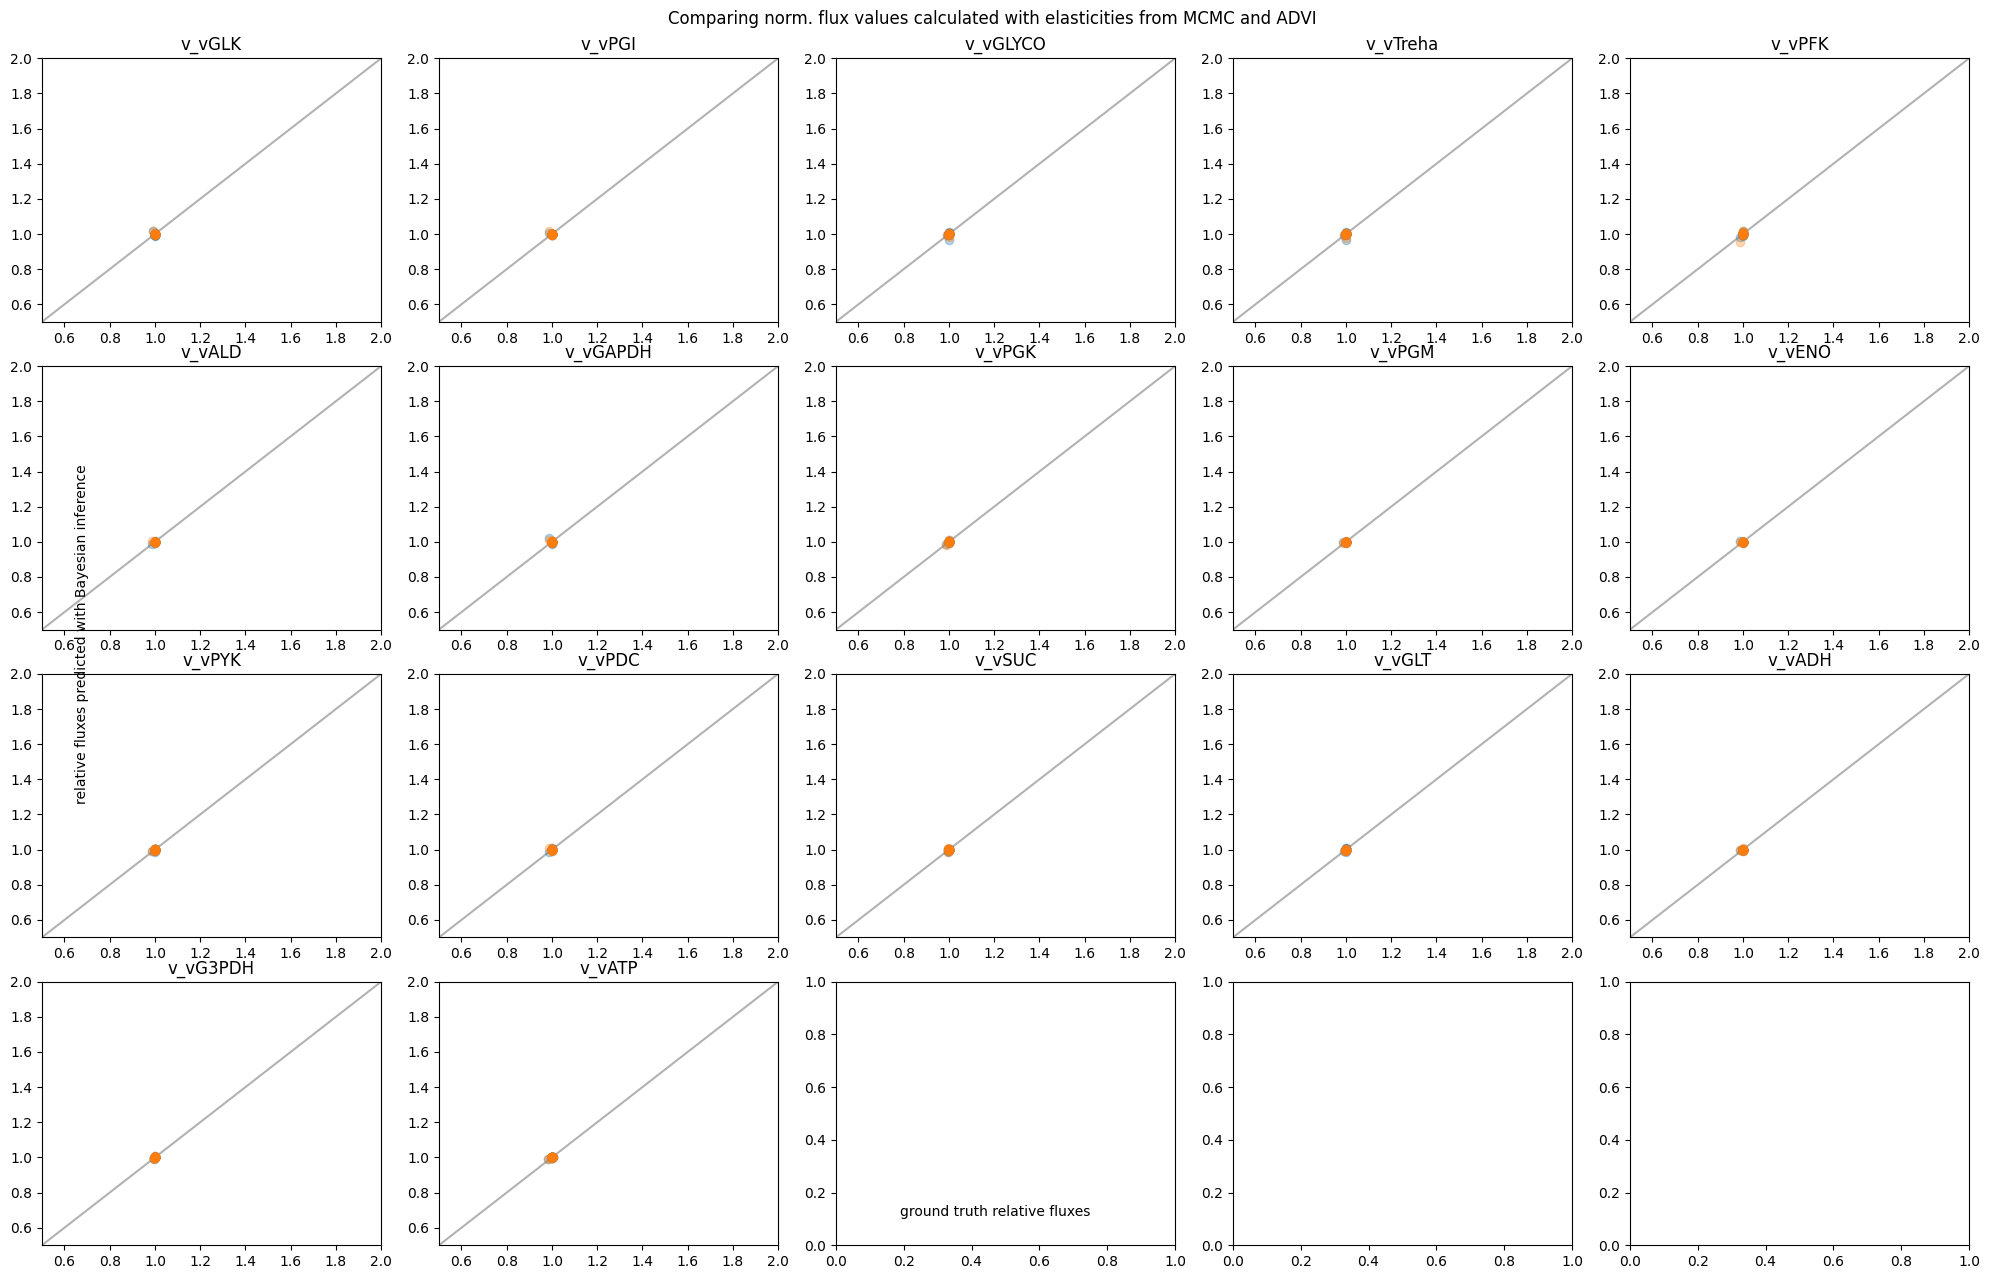

In [45]:
fig, axs = plt.subplots(4,5, figsize=(20, 13)) 
idx_starter = -1

fig.suptitle('Comparing norm. flux values calculated with elasticities from MCMC and ADVI \n')
fig.tight_layout()

lims = [0.5,2]

for i,col in enumerate(MCMC_vn_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(BIOMD64_99.vn[col], MCMC_vn_df_99[col], alpha=0.3)
    axs[idx_starter, i%5].scatter(BIOMD64_99.vn[col], advi_vn_df_99[col], alpha=0.3)
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


### Flux differences

In [46]:
mcmc_dif_09 = MCMC_vn_df_09-BIOMD64_09.vn
# mcmc_dif_09[mcmc_dif_09 < 1E-1] = 0 
mcmc_dif_09

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1,0.099348,0.033387,-0.063707,-0.064378,-0.012922,-3.818489e-04,0.064740,0.005072,0.023098,0.030654,0.013136,-4.800327e-03,-0.011546,-0.144335,1.911680e-02,-0.009477,0.020918
2,-0.053281,-0.042292,0.052844,0.053648,-0.000169,-4.005420e-05,0.000871,0.000076,0.000290,0.000389,0.000153,-7.221687e-05,-0.000164,-0.002088,2.819065e-04,-0.000132,0.000254
3,-0.046084,-0.020345,0.040427,0.045326,0.025341,1.571973e-03,-0.045667,0.008529,-0.011098,-0.019527,0.002408,2.398239e-03,0.010273,0.017307,-8.577455e-03,0.005195,-0.018371
4,-0.032899,-0.014865,0.032064,0.029123,0.016247,9.727376e-04,-0.032607,0.004698,-0.008509,-0.014176,0.000322,1.917738e-03,0.007085,0.012030,-6.681137e-03,0.003883,-0.012695
5,-0.041702,-0.022055,0.041368,0.041998,-0.035386,-1.030397e-05,0.000707,0.000081,0.000241,0.000298,0.000142,-5.717668e-05,-0.000125,-0.001600,2.429207e-04,-0.000118,0.000210
6,-0.008872,-0.004975,0.008794,0.008914,-0.025298,-6.538008e-02,0.000141,0.000016,0.000059,0.000068,0.000036,-3.333013e-07,-0.000039,-0.000319,5.133748e-05,-0.000039,0.000047
7,-0.006448,-0.007328,0.006930,0.007165,-0.099009,4.629186e-02,0.006332,-0.005987,0.005411,0.010409,-0.002038,-1.868280e-02,0.002576,-0.011743,5.185535e-03,0.027446,0.010877
8,-0.000149,-0.000194,0.000161,0.000170,-0.002933,1.317657e-03,-0.017573,-0.078659,0.000159,0.000318,-0.000080,-5.738904e-04,0.000101,-0.000356,1.492032e-04,0.000770,0.000336
9,-0.000126,-0.000161,0.000138,0.000138,-0.002403,1.085754e-03,-0.014468,-0.007389,-0.075158,0.000258,-0.000070,-4.753999e-04,0.000086,-0.000301,1.133717e-04,0.000639,0.000272


In [47]:
advi_dif_09 = advi_vn_df_09-BIOMD64_09.vn
advi_dif_09[advi_dif_09 < 1E-1] = 0 
advi_dif_09

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.102372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.000000,0.111544,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.111224,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129166,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [48]:
mcmc_dif_99 = MCMC_vn_df_99-BIOMD64_99.vn
# mcmc_dif_99[mcmc_dif_99 < 1E-1] = 0 
mcmc_dif_99

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
1,9.102818e-03,2.685418e-03,-0.005260,-5.316735e-03,-0.001064,-5.028457e-05,0.005364,3.512165e-04,1.884236e-03,2.525275e-03,0.001000,-4.722033e-04,-9.174415e-04,-1.309459e-02,1.557272e-03,-7.864325e-04,0.001721
2,-4.913208e-03,-4.163855e-03,0.004865,4.938993e-03,-0.000015,-3.658967e-06,0.000077,6.605463e-06,2.556621e-05,3.435748e-05,0.000014,-6.378537e-06,-1.454355e-05,-1.846341e-04,2.503157e-05,-1.171107e-05,0.000022
3,-4.587553e-03,-2.067573e-03,0.004418,4.501895e-03,0.002533,1.405183e-04,-0.004529,7.921182e-04,-1.116497e-03,-1.943268e-03,0.000141,2.244129e-04,1.047673e-03,1.772025e-03,-8.660141e-04,5.119524e-04,-0.001832
4,-3.279686e-03,-1.503100e-03,0.003192,3.188564e-03,0.001624,8.918950e-05,-0.003241,4.394336e-04,-8.542147e-04,-1.413075e-03,-0.000014,1.815641e-04,7.185454e-04,1.223037e-03,-6.720861e-04,3.845504e-04,-0.001267
5,-3.746286e-03,-2.113728e-03,0.003712,3.768104e-03,-0.003495,-8.689745e-07,0.000062,6.765454e-06,2.096386e-05,2.583205e-05,0.000012,-4.972562e-06,-1.091446e-05,-1.390420e-04,2.129289e-05,-1.029061e-05,0.000018
6,-7.927735e-04,-4.507887e-04,0.000786,7.963492e-04,-0.002297,-6.558145e-03,0.000013,5.856050e-07,5.242442e-06,6.074660e-06,0.000003,-1.091300e-08,-3.532237e-06,-2.825495e-05,4.568713e-06,-3.470169e-06,0.000004
7,-4.816694e-04,-6.383332e-04,0.000527,5.468779e-04,-0.009330,4.188997e-03,0.001064,-5.950639e-04,5.155455e-04,9.999916e-04,-0.000230,-1.810146e-03,2.888189e-04,-1.107530e-03,4.914598e-04,2.479988e-03,0.001044
8,-1.348004e-05,-1.761015e-05,0.000015,1.533532e-05,-0.000267,1.197104e-04,-0.001626,-7.835426e-03,1.447532e-05,2.893498e-05,-0.000007,-5.224719e-05,9.198629e-06,-3.237468e-05,1.356201e-05,6.994959e-05,0.000031
9,-1.132930e-05,-1.453954e-05,0.000012,1.246183e-05,-0.000218,9.829920e-05,-0.001329,-6.862793e-04,-7.487262e-03,2.341017e-05,-0.000006,-4.311491e-05,7.865928e-06,-2.725567e-05,1.025065e-05,5.784447e-05,0.000025


In [49]:
advi_dif_99 = advi_vn_df_99-BIOMD64_99.vn
# advi_dif_99[advi_dif_99 < 1E-1] = 0 
advi_dif_99

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.000195,0.000011,0.000042,-0.000720,0.001415,0.000068,-0.000282,0.001400,0.000277,0.000110,8.284131e-04,0.001468,0.001481,-0.005267,0.001354,-0.000218,-0.001200
2,-0.007142,-0.001277,0.005483,0.006994,-0.000601,-0.000029,0.001053,-0.000145,0.000256,0.000129,-3.370666e-05,0.000014,-0.000453,-0.000225,-0.000260,0.000056,0.000515
3,-0.002498,-0.003078,0.002132,0.002946,0.004138,-0.001330,-0.002492,0.001830,-0.000397,-0.000689,3.374690e-04,-0.002035,-0.000023,0.000309,-0.000879,0.000018,-0.001012
4,-0.001830,-0.002223,0.001547,0.002104,0.002919,-0.001037,-0.001769,0.001154,-0.000345,-0.000534,1.470228e-04,-0.001515,-0.000047,0.000203,-0.000681,-0.000004,-0.000674
5,-0.003970,-0.005806,0.002108,0.003127,-0.004103,0.000487,0.002651,-0.000751,0.000387,0.000524,5.134460e-05,0.000214,-0.001159,-0.000499,-0.000348,0.000394,0.001210
6,-0.000736,-0.001219,0.000380,0.000600,-0.001603,-0.006481,0.000638,-0.000003,0.000076,0.000078,2.568624e-05,-0.000748,-0.000204,-0.000070,-0.000035,0.000097,0.000221
7,-0.001452,-0.002529,0.000146,0.000518,-0.004724,-0.002426,0.003147,-0.001092,0.000528,0.000378,-1.148111e-04,-0.005295,0.001568,-0.000431,0.000096,-0.001955,0.001293
8,0.000070,0.000106,-0.000134,-0.000179,-0.000098,-0.000171,-0.002222,-0.006783,0.000087,0.000040,2.343739e-07,-0.000347,-0.000030,-0.000017,0.000032,-0.000033,0.000123
9,0.000138,0.000113,-0.000183,-0.000170,0.000378,-0.000293,-0.001640,-0.001017,-0.008113,0.000025,3.656974e-05,-0.000504,-0.000017,-0.000020,0.000046,-0.000045,0.000094
